### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

### Carregamento dos dados

In [2]:
dataOriginal = pd.read_csv('new_Global_Superstore_With_Outliers.csv', index_col=0, comment='#') 
df = dataOriginal 

### Tratamento dos dados

In [3]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

y = dataOriginal[['Profit']]
df = dataOriginal

ss = StandardScaler()

ss.fit(df)
df = pd.DataFrame(ss.transform(df))

ss_y = StandardScaler()
ss_y.fit(y)
y = pd.DataFrame(ss_y.transform(y))
#y = ss_y.inverse_transform(pd.DataFrame(y))

pt = PowerTransformer()
pt.fit(df)
#df = pt.transform(df)
df = pd.DataFrame(pt.transform(df))

pt_y = PowerTransformer()
pt_y.fit(y)
#df = pt.transform(df)
y = pd.DataFrame(pt_y.transform(y))
#y = pt_y.inverse_transform(pd.DataFrame(y))


scaler = MinMaxScaler(feature_range = (0,1))
df = pd.DataFrame(scaler.fit_transform(df))

scaler_y = MinMaxScaler(feature_range = (0,1))
y = scaler_y.fit_transform(y)


def unscale(value):
    value_res = value
    value_res = scaler_y.inverse_transform(pd.DataFrame(value_res))
    value_res = pt_y.inverse_transform(pd.DataFrame(value_res))
    value_res = ss_y.inverse_transform(pd.DataFrame(value_res))
 
    return value_res




### Neurónios

In [5]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
import sklearn

RANDOM_SEED = 2021

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


In [6]:
dataset_MLP = df

X_MLP = dataset_MLP.drop(11, axis=1)
y_MLP = dataset_MLP[[11]]
#df.hist(figsize=(14, 14));
small_dataset = False
if small_dataset: 
    remove_n = 40000
    drop_indices = np.random.choice(dataset_MLP.index, remove_n, replace=False)
    dataset_MLP_subset = dataset_MLP.drop(drop_indices)
    X_MLP = dataset_MLP_subset.drop(11, axis=1)
    y_MLP = dataset_MLP_subset[[11]]


In [7]:

X_train, X_test, y_train, y_test = train_test_split(X_MLP, y_MLP, test_size=0.2, random_state=RANDOM_SEED)

number_columns = len(X_train.columns)#.count()
#print("Número de colunas: ", number_columns)

def build_model(activation='relu', learning_rate=0.01, hidden_neurons = 6):
#create a sequential model (with three Layers - Last one is the output)
    model = Sequential()
    model.add(Dense(number_columns, input_dim=number_columns, activation=activation))
    model.add(Dense(6, activation=activation))
    model.add(Dense(1, activation='relu'))
  
     #compile the model
    #Define the Loss function, the otimizer and metrics to be used
    model. compile(
        loss = 'mse',
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ['mse'])
    return model

model = build_model()
model.summary()


TUNING_DICT = {'learning_rate': [0.01,0.03, 0.1],                  
                'activation' : ['relu', 'sigmoid'],
               'hidden_neurons' : [4, 6, 8, 12, 16],
                 }

kf = KFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)
grid_search = GridSearchCV(estimator = model,
                            param_grid = TUNING_DICT,
                            cv = kf,
                            scoring = 'neg_mean_squared_error',
                            refit ='True',
                            verbose = 1)

grid_search.fit(X_train, y_train, validation_split=0.2)

print(" Results from Grid Search " )
print(grid_search)
#print("\n The best score across ALL searched params:\n",grid_search.best_score_)
#print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 23)                552       
                                                                 
 dense_1 (Dense)             (None, 6)                 144       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 703
Trainable params: 703
Non-trainable params: 0
_________________________________________________________________
Fitting 2 folds for each of 30 candidates, totalling 60 fits


C:\Users\Diogo\AppData\Local\Temp\ipykernel_1008\2101411835.py:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)


Epoch 1/15
713/713 [==============================] - 4s 3ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 1.4350e-04 - val_mse: 1.4350e-04
Epoch 2/15
713/713 [==============================] - 2s 3ms/step - loss: 1.5413e-04 - mse: 1.5413e-04 - val_loss: 8.1647e-05 - val_mse: 8.1647e-05
Epoch 3/15
713/713 [==============================] - 2s 3ms/step - loss: 1.3759e-04 - mse: 1.3759e-04 - val_loss: 1.7110e-04 - val_mse: 1.7110e-04
Epoch 4/15
713/713 [==============================] - 2s 3ms/step - loss: 1.2860e-04 - mse: 1.2860e-04 - val_loss: 6.4900e-05 - val_mse: 6.4900e-05
Epoch 5/15
713/713 [==============================] - 2s 2ms/step - loss: 1.1850e-04 - mse: 1.1850e-04 - val_loss: 8.5892e-05 - val_mse: 8.5892e-05
Epoch 6/15
713/713 [==============================] - 2s 3ms/step - loss: 1.1528e-04 - mse: 1.1528e-04 - val_loss: 5.4507e-05 - val_mse: 5.4507e-05
Epoch 7/15
713/713 [==============================] - 3s 4ms/step - loss: 1.0789e-04 - mse: 1.0789e-04 - val_loss: 5.310

713/713 [==============================] - 2s 2ms/step - loss: 1.1416e-04 - mse: 1.1416e-04 - val_loss: 2.0153e-04 - val_mse: 2.0153e-04
Epoch 8/15
713/713 [==============================] - 2s 2ms/step - loss: 1.1478e-04 - mse: 1.1478e-04 - val_loss: 1.1393e-04 - val_mse: 1.1393e-04
Epoch 9/15
713/713 [==============================] - 2s 2ms/step - loss: 1.1246e-04 - mse: 1.1246e-04 - val_loss: 1.7323e-04 - val_mse: 1.7323e-04
Epoch 10/15
713/713 [==============================] - 2s 2ms/step - loss: 1.0816e-04 - mse: 1.0816e-04 - val_loss: 1.0319e-04 - val_mse: 1.0319e-04
Epoch 11/15
713/713 [==============================] - 2s 3ms/step - loss: 1.1362e-04 - mse: 1.1362e-04 - val_loss: 1.2024e-04 - val_mse: 1.2024e-04
Epoch 12/15
713/713 [==============================] - 3s 4ms/step - loss: 1.1213e-04 - mse: 1.1213e-04 - val_loss: 1.0250e-04 - val_mse: 1.0250e-04
Epoch 13/15
713/713 [==============================] - 2s 3ms/step - loss: 1.0970e-04 - mse: 1.0970e-04 - val_loss: 1.16

713/713 [==============================] - 2s 3ms/step - loss: 1.2124e-04 - mse: 1.2124e-04 - val_loss: 1.1715e-04 - val_mse: 1.1715e-04
Epoch 12/15
713/713 [==============================] - 2s 3ms/step - loss: 1.2374e-04 - mse: 1.2374e-04 - val_loss: 7.4837e-05 - val_mse: 7.4837e-05
Epoch 13/15
713/713 [==============================] - 2s 3ms/step - loss: 1.2823e-04 - mse: 1.2823e-04 - val_loss: 6.2577e-05 - val_mse: 6.2577e-05
Epoch 14/15
713/713 [==============================] - 2s 2ms/step - loss: 1.3627e-04 - mse: 1.3627e-04 - val_loss: 1.4047e-04 - val_mse: 1.4047e-04
Epoch 15/15
891/891 [==============================] - 1s 1ms/step
Epoch 1/15
713/713 [==============================] - 3s 3ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 2.0874e-04 - val_mse: 2.0874e-04
Epoch 2/15
713/713 [==============================] - 2s 3ms/step - loss: 1.5880e-04 - mse: 1.5880e-04 - val_loss: 1.3464e-04 - val_mse: 1.3464e-04
Epoch 3/15
713/713 [==============================] - 2s 3ms/

891/891 [==============================] - 2s 2ms/step
Epoch 1/15
713/713 [==============================] - 3s 3ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 7.5868e-05 - val_mse: 7.5868e-05
Epoch 2/15
713/713 [==============================] - 2s 3ms/step - loss: 1.1095e-04 - mse: 1.1095e-04 - val_loss: 6.2994e-05 - val_mse: 6.2994e-05
Epoch 3/15
713/713 [==============================] - 2s 3ms/step - loss: 1.1270e-04 - mse: 1.1270e-04 - val_loss: 1.6060e-04 - val_mse: 1.6060e-04
Epoch 4/15
713/713 [==============================] - 2s 2ms/step - loss: 1.2282e-04 - mse: 1.2282e-04 - val_loss: 1.5134e-04 - val_mse: 1.5134e-04
Epoch 5/15
713/713 [==============================] - 2s 2ms/step - loss: 1.1852e-04 - mse: 1.1852e-04 - val_loss: 7.2703e-05 - val_mse: 7.2703e-05
Epoch 6/15
713/713 [==============================] - 2s 2ms/step - loss: 1.2205e-04 - mse: 1.2205e-04 - val_loss: 5.6324e-05 - val_mse: 5.6324e-05
Epoch 7/15
713/713 [==============================] - 2s 3ms/step

Epoch 9/15
713/713 [==============================] - 2s 3ms/step - loss: 2.0127e-04 - mse: 2.0127e-04 - val_loss: 3.4227e-04 - val_mse: 3.4227e-04
Epoch 10/15
713/713 [==============================] - 2s 2ms/step - loss: 1.9697e-04 - mse: 1.9697e-04 - val_loss: 1.4646e-04 - val_mse: 1.4646e-04
Epoch 11/15
713/713 [==============================] - 2s 2ms/step - loss: 1.9497e-04 - mse: 1.9497e-04 - val_loss: 2.3004e-04 - val_mse: 2.3004e-04
Epoch 12/15
713/713 [==============================] - 2s 2ms/step - loss: 1.8843e-04 - mse: 1.8843e-04 - val_loss: 1.4436e-04 - val_mse: 1.4436e-04
Epoch 13/15
713/713 [==============================] - 2s 3ms/step - loss: 1.8644e-04 - mse: 1.8644e-04 - val_loss: 3.0313e-04 - val_mse: 3.0313e-04
Epoch 14/15
713/713 [==============================] - 2s 3ms/step - loss: 1.9340e-04 - mse: 1.9340e-04 - val_loss: 8.8781e-04 - val_mse: 8.8781e-04
Epoch 15/15
891/891 [==============================] - 2s 2ms/step
Epoch 1/15
713/713 [====================

713/713 [==============================] - 1s 2ms/step - loss: 1.2924e-04 - mse: 1.2924e-04 - val_loss: 1.1980e-04 - val_mse: 1.1980e-04
Epoch 7/15
713/713 [==============================] - 2s 2ms/step - loss: 1.3476e-04 - mse: 1.3476e-04 - val_loss: 1.0185e-04 - val_mse: 1.0185e-04
Epoch 8/15
713/713 [==============================] - 2s 2ms/step - loss: 1.2164e-04 - mse: 1.2164e-04 - val_loss: 9.6451e-05 - val_mse: 9.6451e-05
Epoch 9/15
713/713 [==============================] - 2s 2ms/step - loss: 1.3676e-04 - mse: 1.3676e-04 - val_loss: 1.1027e-04 - val_mse: 1.1027e-04
Epoch 10/15
713/713 [==============================] - 2s 3ms/step - loss: 1.2365e-04 - mse: 1.2365e-04 - val_loss: 1.6586e-04 - val_mse: 1.6586e-04
Epoch 11/15
713/713 [==============================] - 2s 3ms/step - loss: 1.1979e-04 - mse: 1.1979e-04 - val_loss: 1.6354e-04 - val_mse: 1.6354e-04
Epoch 12/15
713/713 [==============================] - 2s 3ms/step - loss: 1.2822e-04 - mse: 1.2822e-04 - val_loss: 9.326

713/713 [==============================] - 2s 3ms/step - loss: 1.5734e-04 - mse: 1.5734e-04 - val_loss: 1.1739e-04 - val_mse: 1.1739e-04
Epoch 4/15
713/713 [==============================] - 2s 2ms/step - loss: 1.4965e-04 - mse: 1.4965e-04 - val_loss: 3.3634e-04 - val_mse: 3.3634e-04
Epoch 5/15
713/713 [==============================] - 2s 3ms/step - loss: 1.3920e-04 - mse: 1.3920e-04 - val_loss: 1.5709e-04 - val_mse: 1.5709e-04
Epoch 6/15
713/713 [==============================] - 2s 3ms/step - loss: 1.3824e-04 - mse: 1.3824e-04 - val_loss: 9.8815e-05 - val_mse: 9.8815e-05
Epoch 7/15
713/713 [==============================] - 2s 2ms/step - loss: 1.3465e-04 - mse: 1.3465e-04 - val_loss: 1.0701e-04 - val_mse: 1.0701e-04
Epoch 8/15
713/713 [==============================] - 1s 2ms/step - loss: 1.2744e-04 - mse: 1.2744e-04 - val_loss: 1.1965e-04 - val_mse: 1.1965e-04
Epoch 9/15
713/713 [==============================] - 1s 2ms/step - loss: 1.1820e-04 - mse: 1.1820e-04 - val_loss: 1.0992e-

Epoch 10/15
713/713 [==============================] - 2s 3ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 11/15
713/713 [==============================] - 2s 3ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 12/15
713/713 [==============================] - 2s 3ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 13/15
713/713 [==============================] - 2s 3ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 14/15
713/713 [==============================] - 3s 4ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 15/15
891/891 [==============================] - 1s 1ms/step
Epoch 1/15
713/713 [==============================] - 2s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3191 - val_mse: 0.3191
Epoch 2/15
713/713 [==============================] - 2s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3191 - val_mse: 0.3191
Epoc

Epoch 3/15
713/713 [==============================] - 2s 3ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 4/15
713/713 [==============================] - 2s 3ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 5/15
713/713 [==============================] - 2s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 6/15
713/713 [==============================] - 1s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 7/15
713/713 [==============================] - 1s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 8/15
713/713 [==============================] - 2s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 9/15
713/713 [==============================] - 1s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 10/15
713/713 [==============================] - 2s 2ms/step - loss: 0

713/713 [==============================] - 2s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3191 - val_mse: 0.3191
Epoch 14/15
713/713 [==============================] - 1s 2ms/step - loss: 0.3194 - mse: 0.3194 - val_loss: 0.3191 - val_mse: 0.3191
Epoch 15/15
891/891 [==============================] - 2s 2ms/step
Epoch 1/15
1425/1425 [==============================] - 5s 3ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 1.4430e-04 - val_mse: 1.4430e-04
Epoch 2/15
1425/1425 [==============================] - 4s 3ms/step - loss: 1.6106e-04 - mse: 1.6106e-04 - val_loss: 1.0593e-04 - val_mse: 1.0593e-04
Epoch 3/15
1425/1425 [==============================] - 3s 2ms/step - loss: 1.2944e-04 - mse: 1.2944e-04 - val_loss: 9.9173e-05 - val_mse: 9.9173e-05
Epoch 4/15
1425/1425 [==============================] - 3s 2ms/step - loss: 1.1063e-04 - mse: 1.1063e-04 - val_loss: 9.2798e-05 - val_mse: 9.2798e-05
Epoch 5/15
1425/1425 [==============================] - 3s 2ms/step - loss: 1.0988e-04 

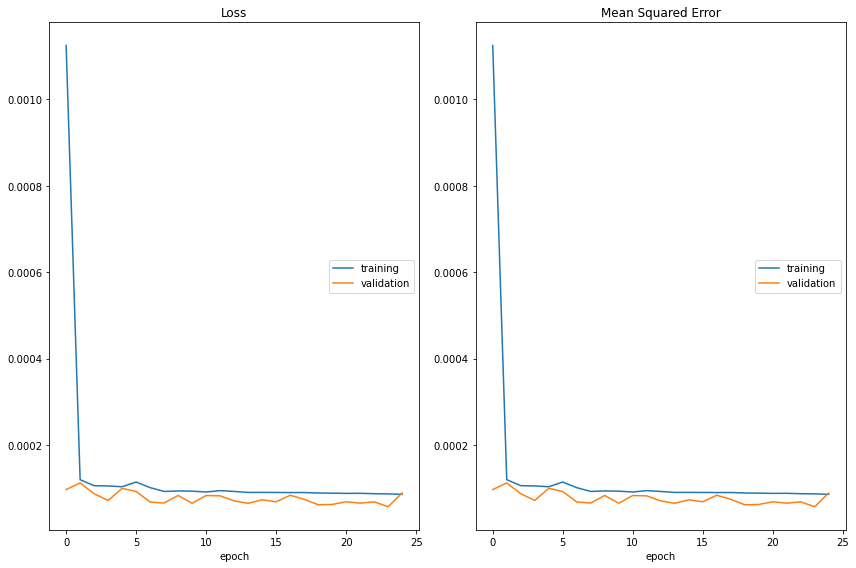

Loss
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
Mean Squared Error
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
1781/1781 [==============================] - 4s 2ms/step - loss: 8.6243e-05 - mse: 8.6243e-05 - val_loss: 8.9525e-05 - val_mse: 8.9525e-05


In [8]:

from livelossplot import PlotLossesKerasTF


best_mlp_model = grid_search.best_estimator_



best_mlp_model.fit(X_train, y_train, epochs=25,
validation_data=(X_test, y_test),
callbacks=[PlotLossesKerasTF()], verbose=1)

### Análise de overfitting

Pelos gráficos, vemos que o medium average error (mae) dá bastante mal, mas o mse dá bem. Como 20 epochs é um valor considerável, consideramos nesta fase melhorar o tratamento de dados, e depois verificar se há melhorias. 
Isto porque, o tratamento de dados atual para este modelo é quase com o objetivo de o modelo consiguir analisar o dataset.

In [9]:
 #0btain predictions

start_time = time.time()
predictions = best_mlp_model.predict(X_test)
print("time - {}".format(time.time()-start_time))

predictions = unscale(predictions)
y_test = unscale(y_test)
#pd.DataFrame(y_test).hist(figsize=(14, 14));
#pd.DataFrame(predictions).hist(figsize=(14, 14));

#y_test_scaled = unscale(y_test)


446/446 [==============================] - 1s 1ms/step
time - 1.031308889389038


Mean Absolute Error:  92.02699958198332
Mean Squared Error:  20092.424359104112
RMSE:  141.74774904422333


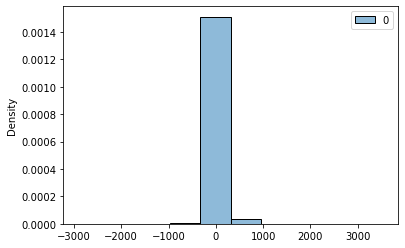

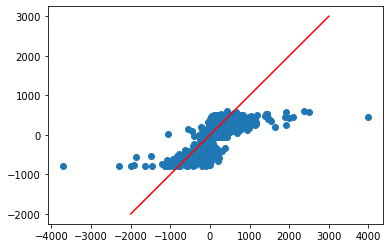

array([[-53.076237],
       [-53.076237],
       [-53.076237],
       ...,
       [-53.076237],
       [-53.076237],
       [-53.076237]], dtype=float32)

In [10]:
from sklearn import metrics

def analise_model(model): 
   
    #model.fit(X_train, y_train)
    #predictions = model.predict(X_test)
    
    #predictions  = predictions.reshape(len(predictions),1 )
    # Métricas
    print(model)
   # print(model.get_params())
    print("Mean Absolute Error: ", mean_absolute_error(y_test, predictions))
    print("Mean Squared Error: ", mean_squared_error(y_test, predictions, squared=True))
    print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    sns.histplot(y_test-predictions, bins=10,stat="density")
    plt.show()
    
    ax = plt.axes()
    ax.plot([-2000, -250, 0, 1500, 3000], [-2000, -250, 0, 1500, 3000], 'r')
    plt.scatter(y_test,predictions)
    plt.show()
    return predictions
    

analise_model(best_mlp_model)

#plt.scatter(y_test,predictions)
#plt.show()

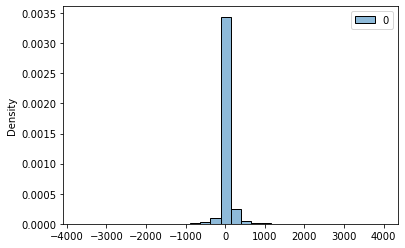

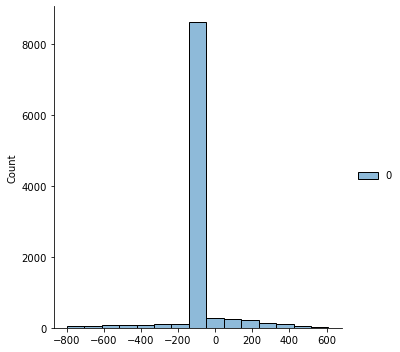

Quartis
[-3.70189280e+03  1.38555833e-13  9.23930000e+00  3.79986000e+01
  3.97908000e+03]


In [11]:
sns.histplot(y_test, bins=30,stat="density")
plt.show()
    
sns.displot(predictions)
plt.show() 

print("Quartis")
x = np.quantile(y_test, [0,0.25,0.5,0.75,1])

print(x)